# Model 1 (Random Forest Regression)

## Importing the necessary libraries

* `pandas`, `numpy`: data manipulation <br>
* `matplotlib`, `seaborn`: visualizations <br>
* `sklearn`: ML and deep learning frameworks <br>
* `OS`: to download and upload files


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import os 


<h3>Getting data from kaggle, its mostly your stuff so you can write to it<h3>

In [22]:
if not os.path.exists("../secrets"):
    os.makedirs("../secrets")
    print("Created directory: ../secrets")
    raise Exception("Place kaggle.json in the secrets directory")
elif not os.path.exists("../secrets/kaggle.json"):
    raise Exception("Place kaggle.json in the secrets directory")


gitignore_path = os.path.join("../secrets", ".gitignore")

if not os.path.exists(gitignore_path):
    with open(gitignore_path, 'w') as f:
        f.write("*\n")


if not os.environ.get('KAGGLE_CONFIG_DIR'):
    os.environ['KAGGLE_CONFIG_DIR'] = os.path.abspath("../secrets")

print("KAGGLE_CONFIG_DIR set to:", os.environ['KAGGLE_CONFIG_DIR'])

from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle

api = KaggleApi()
api.authenticate()

dataset_name = "sid321axn/beijing-multisite-airquality-data-set"

download_dir = "../data"

if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"Created directory: {download_dir}")

print(f"Downloading dataset {dataset_name} to {download_dir}")
api.dataset_download_files(dataset_name, path=download_dir, unzip=True)
print(f"Dataset downloaded and unzipped to {download_dir}")

with open(os.path.join(download_dir, ".gitignore"), 'w') as f:
    f.write("*\n")
print(f"Created .gitignore in {download_dir}")




KAGGLE_CONFIG_DIR set to: /Users/serhanasad/Desktop/midterm/4641_Group/Midterm/secrets
Created directory: ../data
Dataset URL: https://www.kaggle.com/datasets/sid321axn/beijing-multisite-airquality-data-set
Dataset downloaded and unzipped to ../data
Created .gitignore in ../data


### Combining all the dataset files into one file called `combined_data.csv`

In [23]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

combined_data = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)


print("shape" ,combined_data.shape)

combined_data.to_csv(os.path.join(data_folder, 'combined_data.csv'), index=False)

shape (420768, 18)


In [24]:
data = pd.read_csv('../data/combined_data.csv')
print("Shape:", data.shape)
data.head()

Shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


### There are missing values and random forest does not work if there are missing values, so we will find the missing values and fill them using forward_fill and backward_fill. 

In [26]:
missing = data.isnull().sum()
print(missing[missing > 0])

PM2.5     8739
PM10      6449
SO2       9021
NO2      12116
CO       20701
O3       13277
TEMP       398
PRES       393
DEWP       403
RAIN       390
wd        1822
WSPM       318
dtype: int64


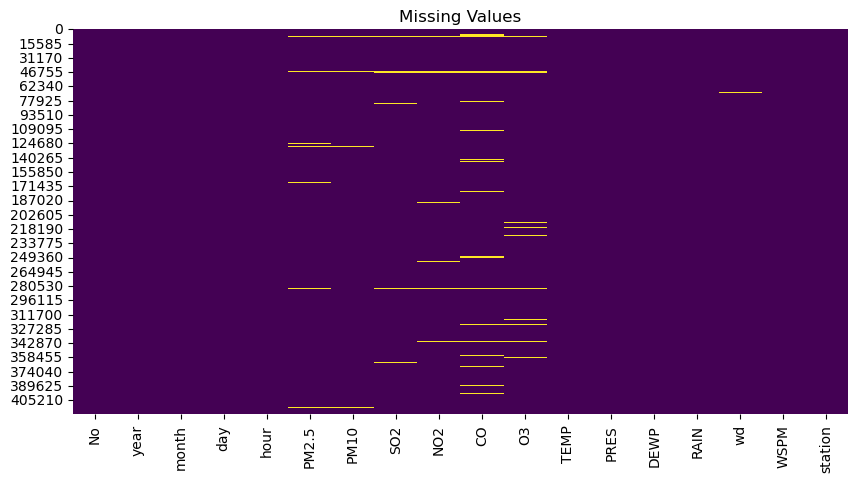

In [27]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values')
plt.show()

In [28]:
missing_percent = (data.isnull().sum() / len(data)) * 100
missing_values = (missing_percent[missing_percent > 0].sort_values(ascending=False))
print(missing_values)

CO       4.919813
O3       3.155421
NO2      2.879497
SO2      2.143937
PM2.5    2.076916
PM10     1.532674
wd       0.433018
DEWP     0.095777
TEMP     0.094589
PRES     0.093401
RAIN     0.092688
WSPM     0.075576
dtype: float64


In [29]:
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')

print("Values that are still missing", data.isnull().sum().sum())

Values that are still missing 0


/var/folders/m7/03m2hb3j4_3df05ypw6v1rvm0000gn/T/ipykernel_5611/3658014593.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
/var/folders/m7/03m2hb3j4_3df05ypw6v1rvm0000gn/T/ipykernel_5611/3658014593.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


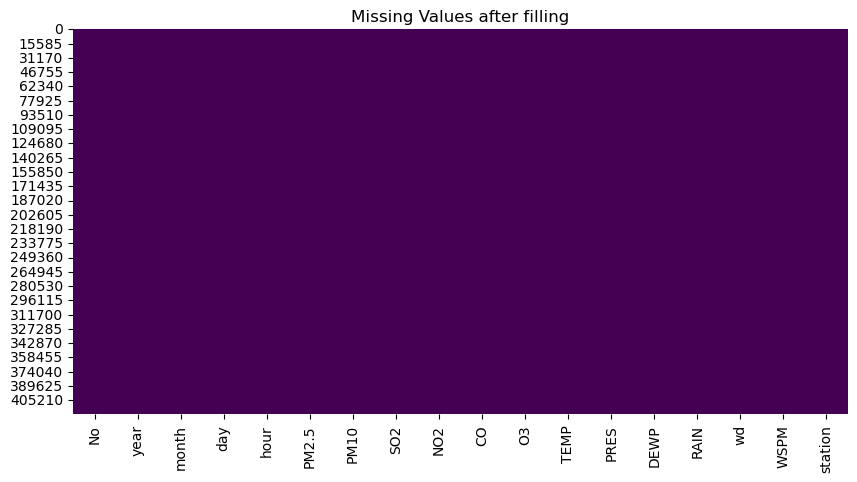

In [30]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values after filling')
plt.show()

In [31]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,5.0,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,5.0,700.0,52.0,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


## Feature reduction
### Removing `No` and `station` as it does not affect AQI. <br>
### **Confirmed through trial and error**

In [32]:
data_features = data.drop(columns=['No','station'])

In [33]:
data_features.head()


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,0,6.0,18.0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4
1,2013,3,1,1,6.0,15.0,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0
2,2013,3,1,2,5.0,18.0,5.0,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6
3,2013,3,1,3,6.0,20.0,6.0,5.0,700.0,52.0,-1.0,1022.7,-21.2,0.0,W,2.8
4,2013,3,1,4,5.0,17.0,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6


### Dropping PM2.5 as that we will use our output label. Also removing PM10 as its closely linked to PM2.5 meaning its indicator of AQI, and we dont our model to learn from nearly identical variable that is closely linked to the output.

In [34]:
X = data_features.drop(columns=['PM2.5','PM10'])
y = data_features['PM2.5']

print("X_shape", X.shape)
print("Y_shape", y.shape)

X_shape (420768, 14)
Y_shape (420768,)


In [35]:
X.head()

,year,month,day,hour,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4
1,2013,3,1,1,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0
2,2013,3,1,2,5.0,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6
3,2013,3,1,3,6.0,5.0,700.0,52.0,-1.0,1022.7,-21.2,0.0,W,2.8
4,2013,3,1,4,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6


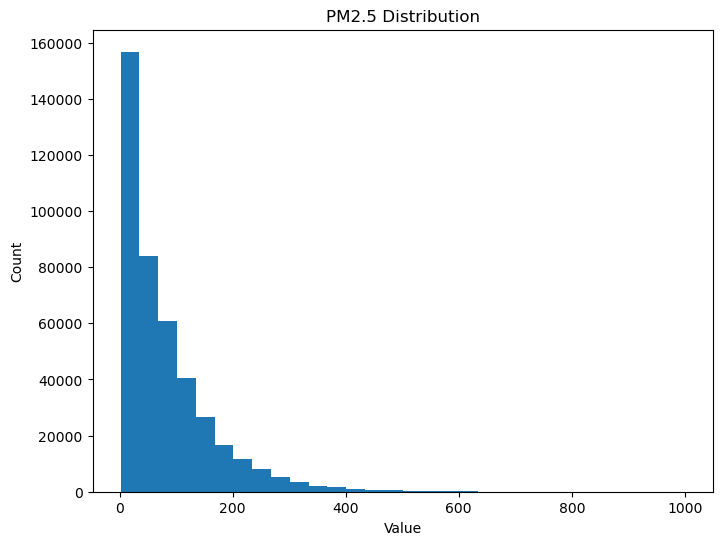

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.hist(y, bins=30)
plt.title("PM2.5 Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


### We will normalize the labels as models do better on normalized data

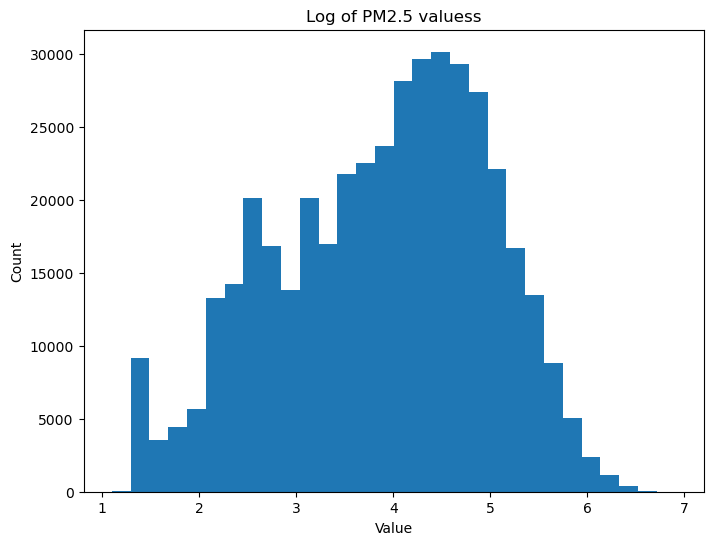

In [37]:
y = np.log1p(y)  # Apply log transformation
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30)
plt.title("Log of PM2.5 valuess")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

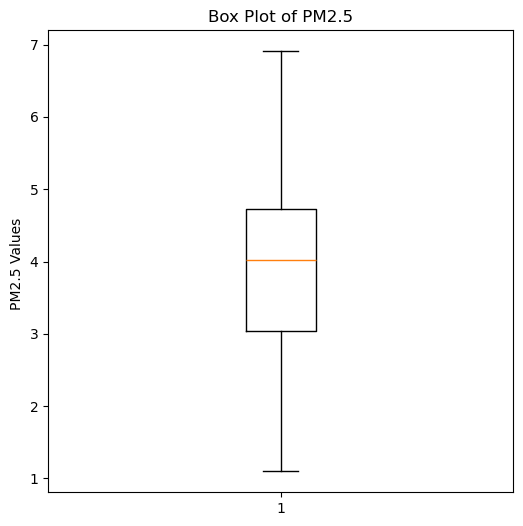

In [38]:
plt.figure(figsize=(6,6))
plt.boxplot(y.dropna())  
plt.title("Box Plot of PM2.5")
plt.ylabel("PM2.5 Values ")
plt.show()

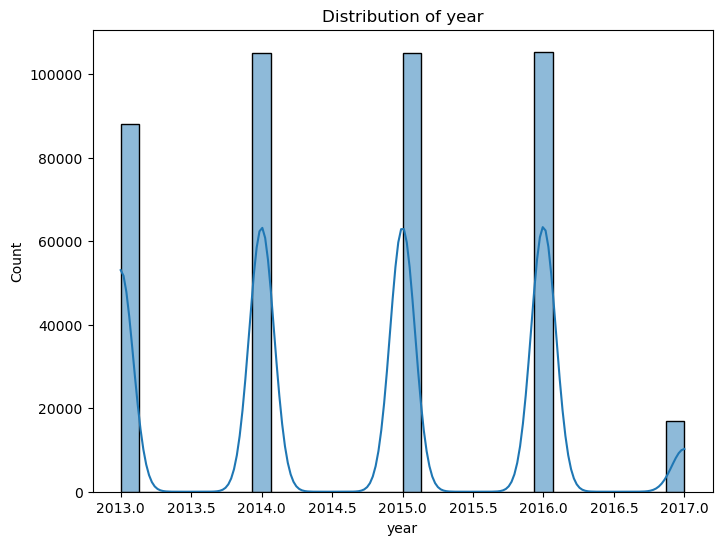

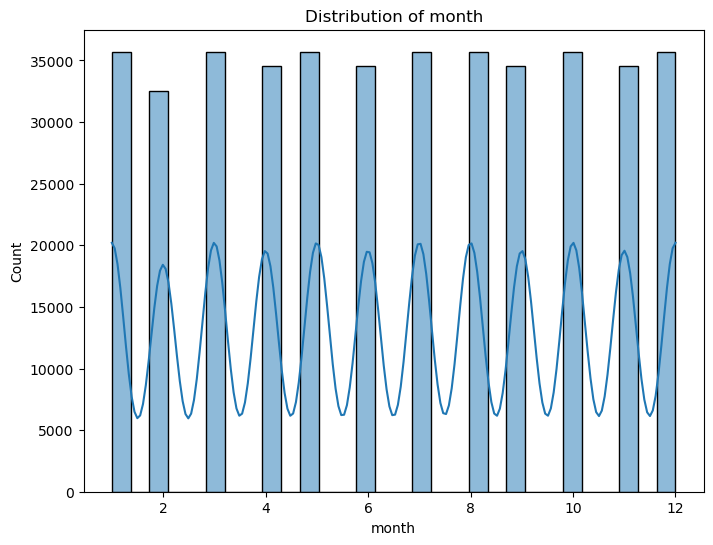

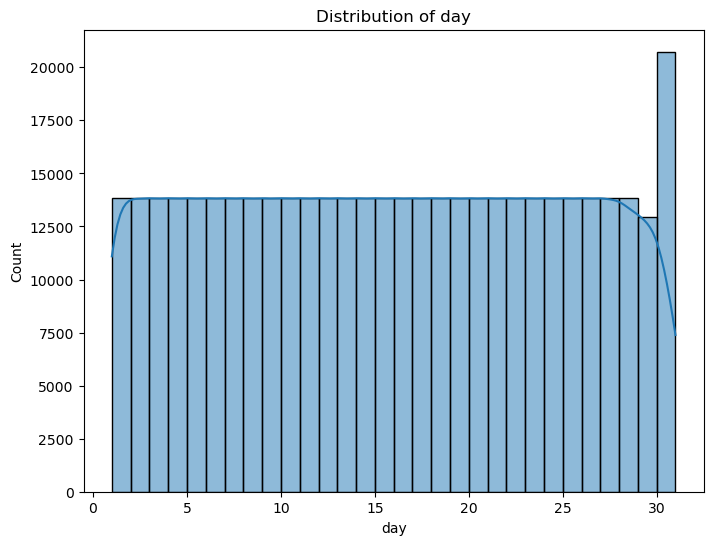

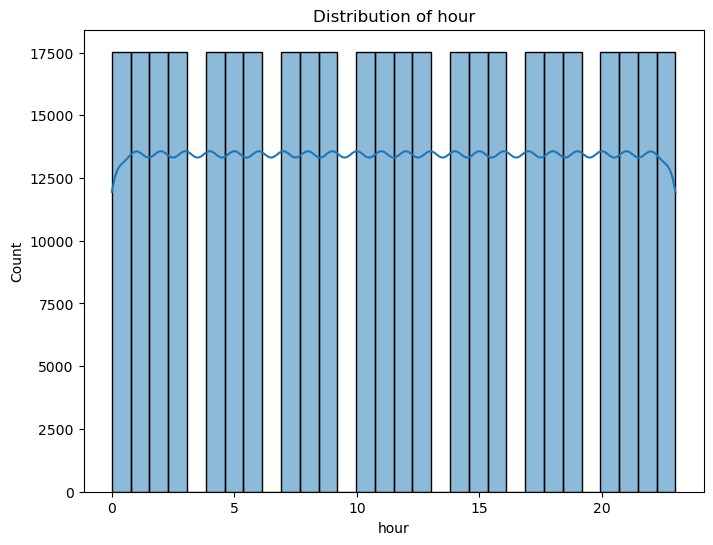

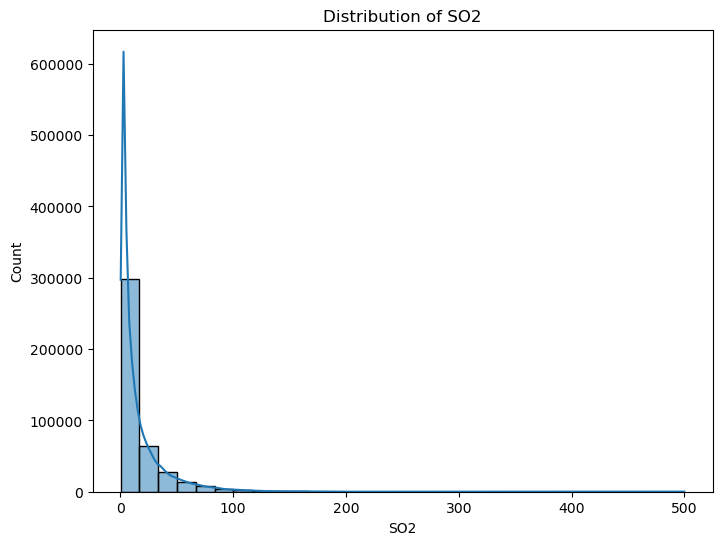

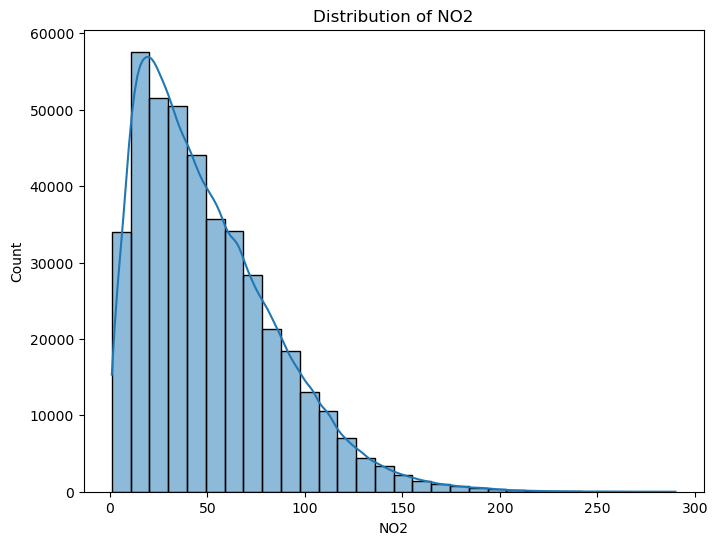

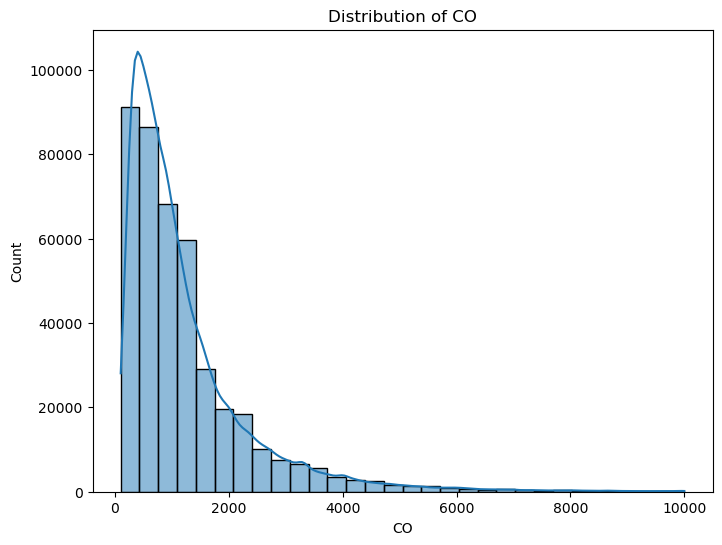

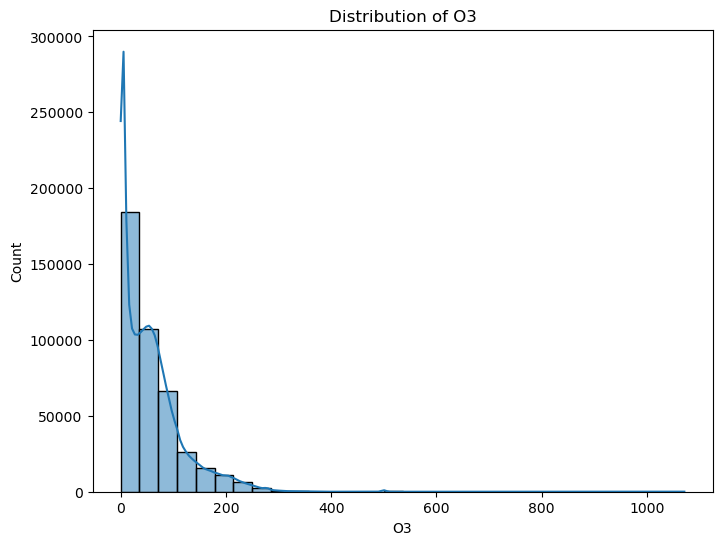

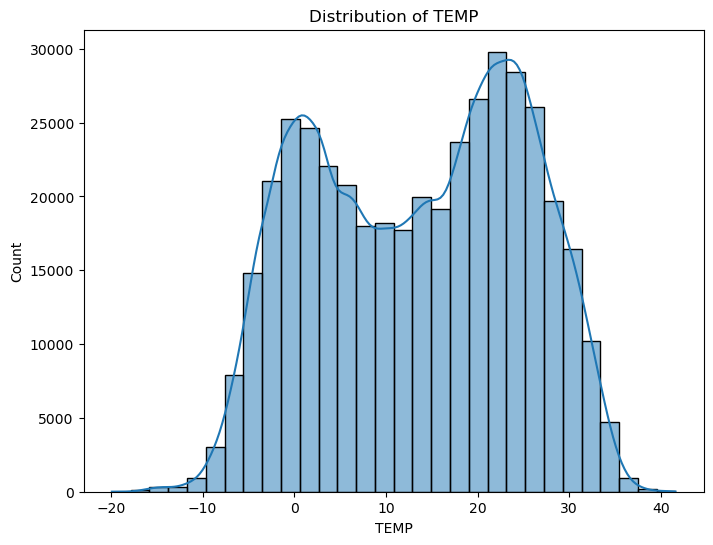

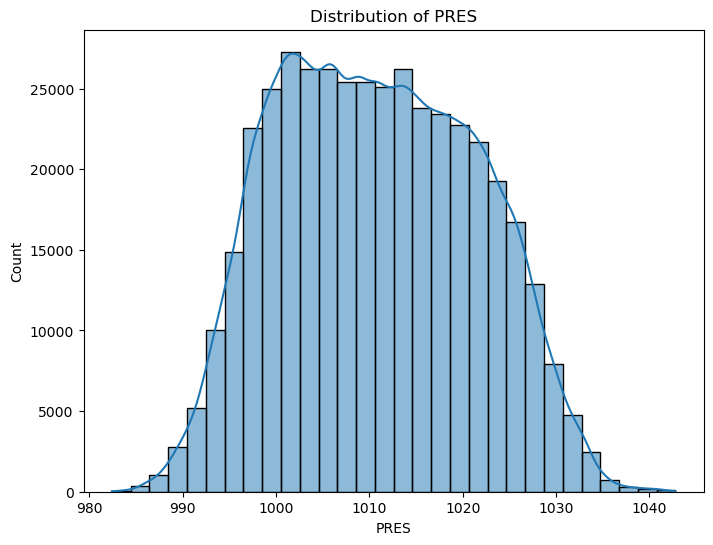

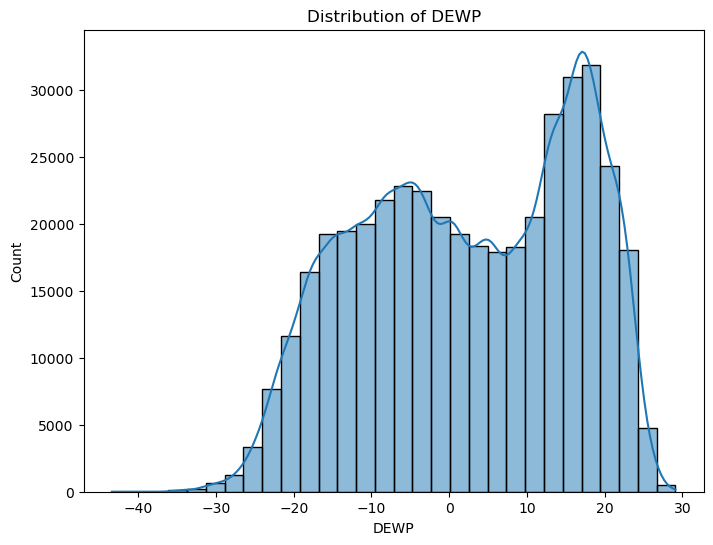

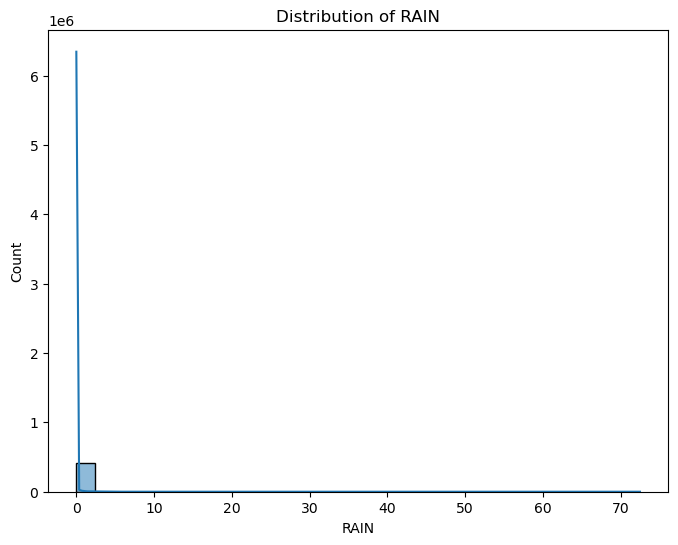

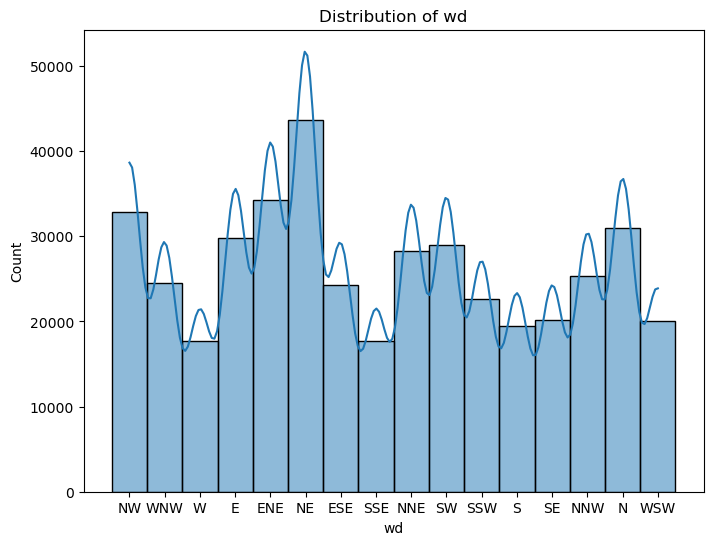

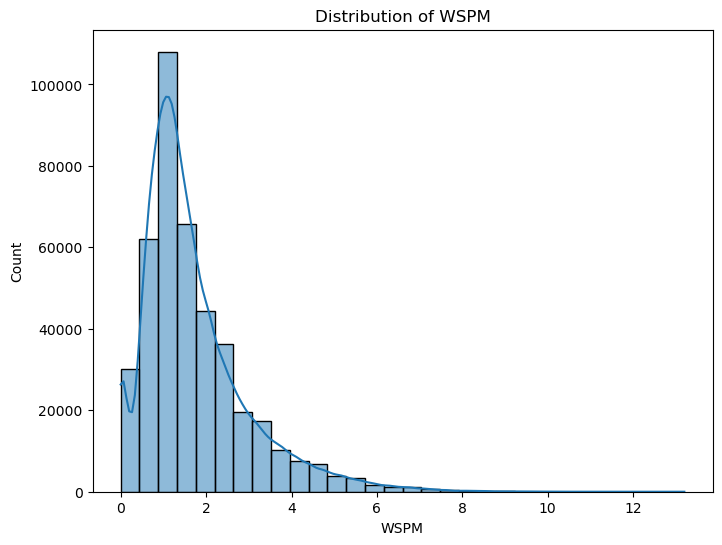

In [39]:
import seaborn as sns

for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

### Same here again we nomralizing the features as well

In [40]:
features = ['RAIN', 'SO2', 'NO2', 'CO', 'O3']
for feature in features:
    X[feature] = np.log1p(X[feature])

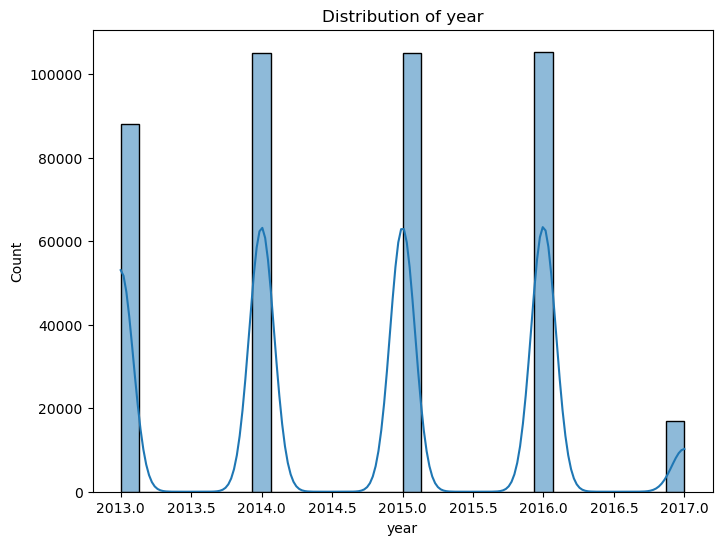

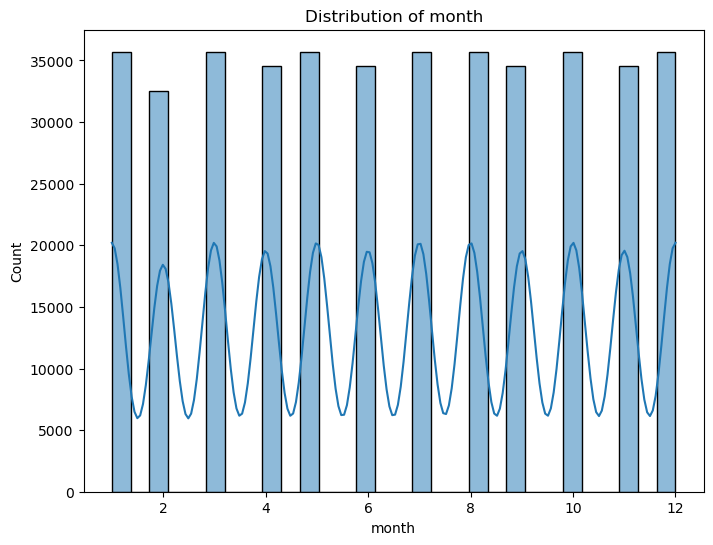

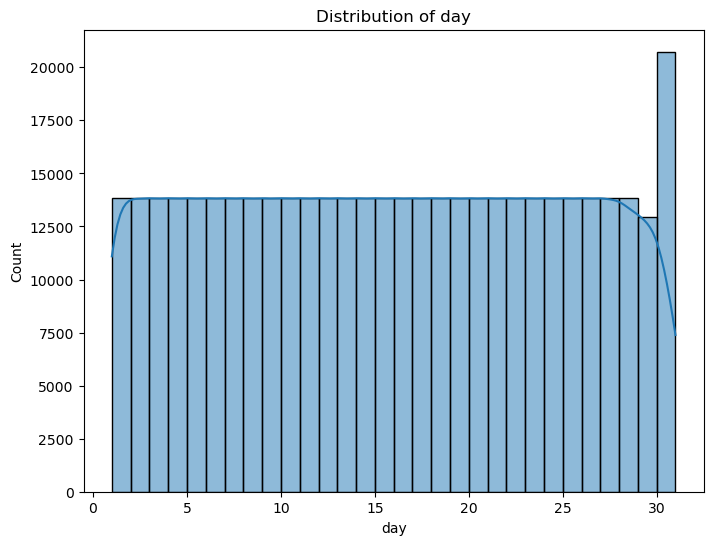

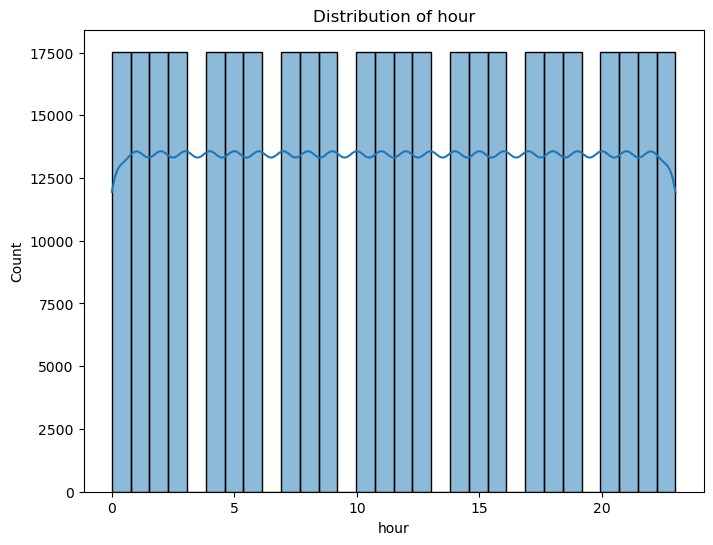

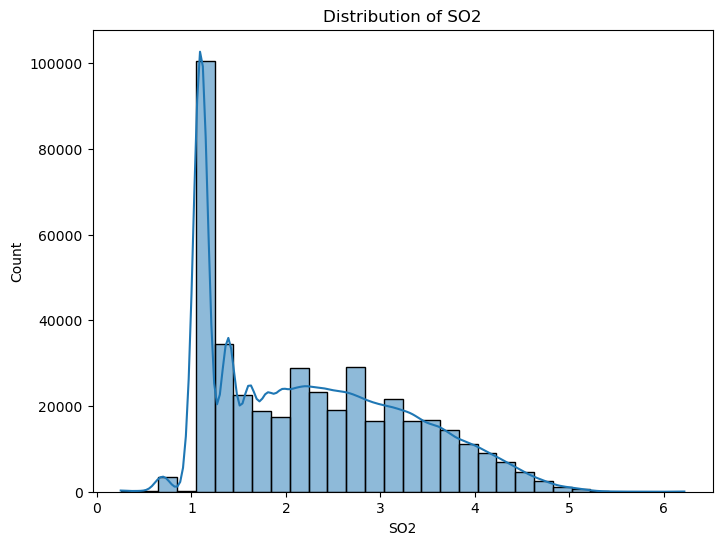

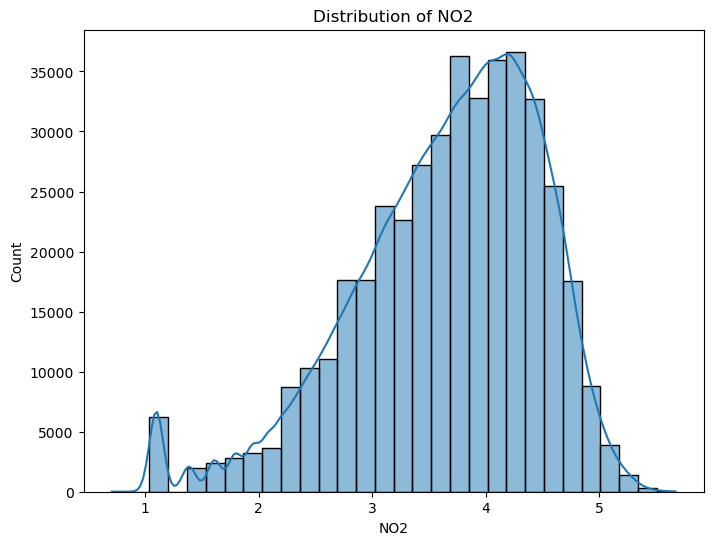

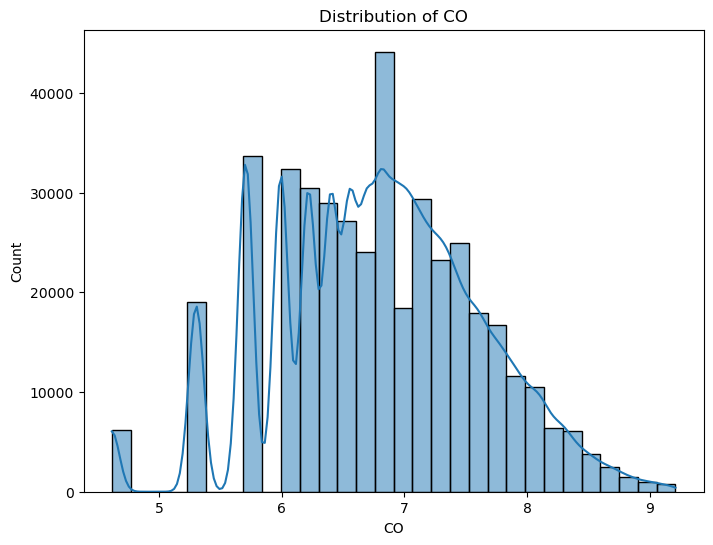

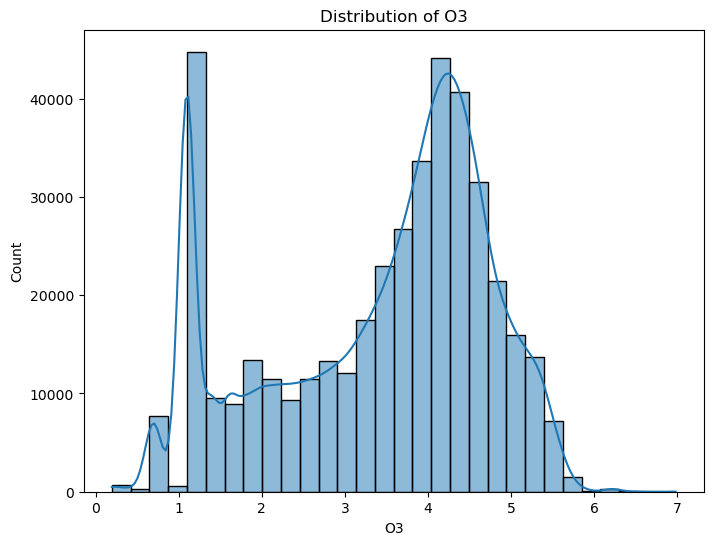

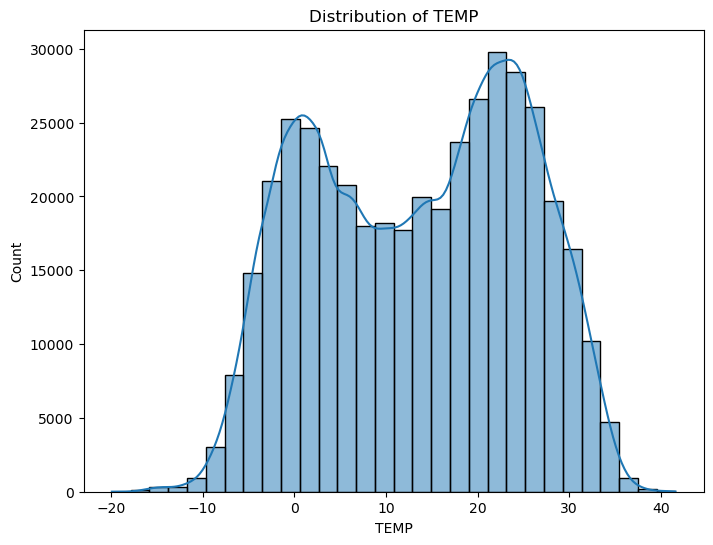

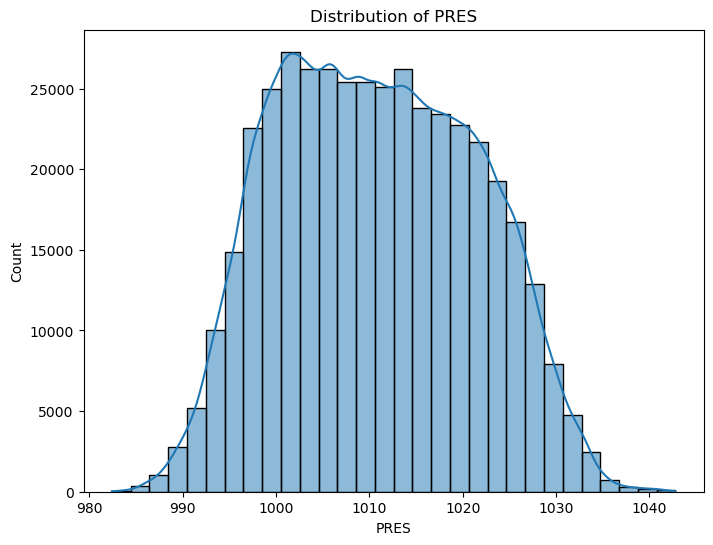

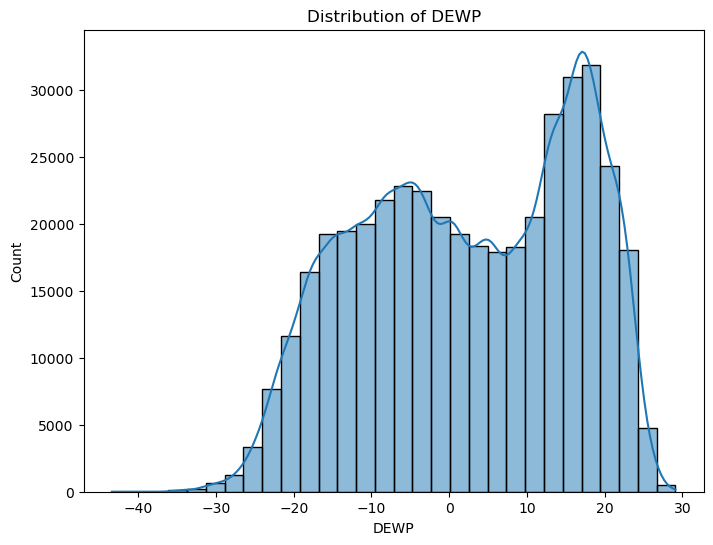

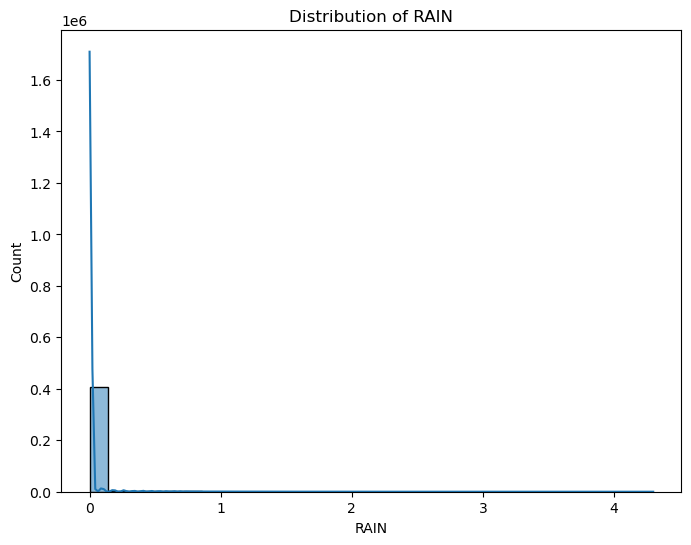

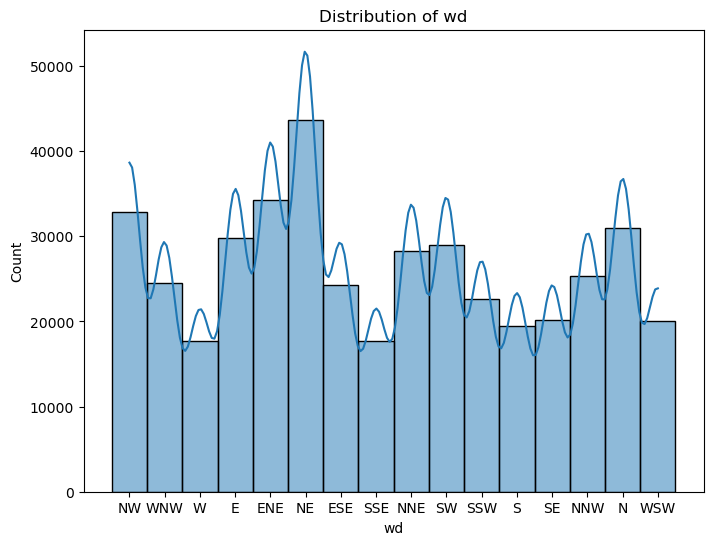

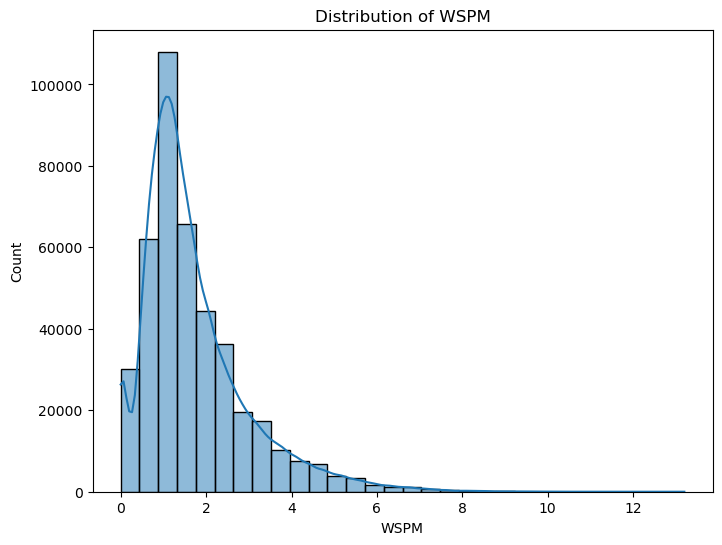

In [41]:
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

### We converting wind direction to one hot encoding, as random forest cant take strings, so we can convert the directions into integers. 

In [42]:
X_encoded = pd.get_dummies(X, columns=['wd'], drop_first=True)

### We made the correlation matrix to see how correlated the features are, we dont have that many features and also they dont correlate that much, so we dont have to do feature reduction. 

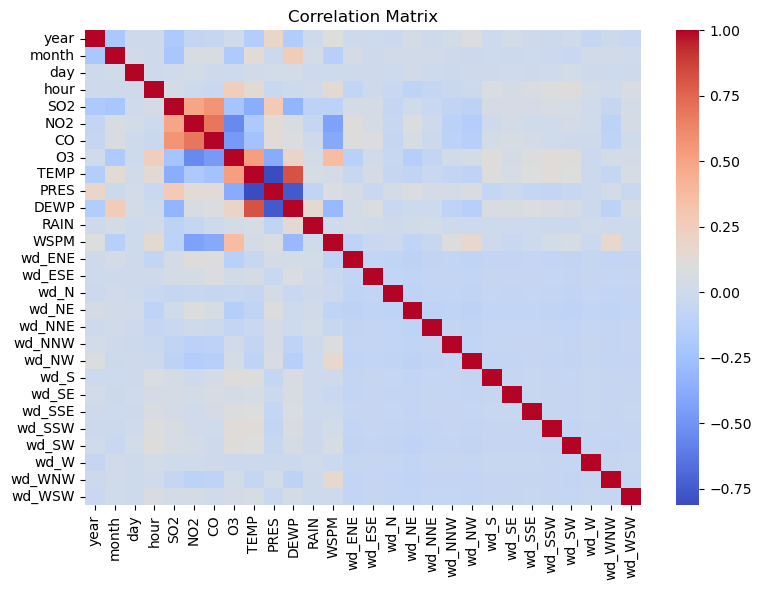

In [43]:

corr_matrix = X_encoded.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
X_encoded.head()

,year,month,day,hour,SO2,NO2,CO,O3,TEMP,PRES,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2013,3,1,0,1.791759,1.791759,6.685861,4.488636,0.1,1021.1,...,False,True,False,False,False,False,False,False,False,False
1,2013,3,1,1,1.791759,1.791759,6.685861,4.488636,-0.3,1021.5,...,False,True,False,False,False,False,False,False,False,False
2,2013,3,1,2,1.791759,1.791759,6.552508,3.970292,-0.7,1021.5,...,False,False,False,False,False,False,False,False,True,False
3,2013,3,1,3,1.945910,1.791759,6.552508,3.970292,-1.0,1022.7,...,False,False,False,False,False,False,False,True,False,False
4,2013,3,1,4,1.791759,1.791759,6.398595,4.304065,-1.3,1023.0,...,False,False,False,False,False,False,False,False,True,False


### splitting the data based on years, into train and test

In [45]:

train = X_encoded[(X_encoded['year'] >= 2013) & (X_encoded['year'] <= 2016)]
test = X_encoded[(X_encoded['year'] == 2017) & (X_encoded['month'] <= 2)]

X_train = train
y_train = y.loc[train.index]
X_test = test
y_test = y.loc[test.index]

### Normalizing the input as models train faster and with less bias on normalized input

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print( X_train_scaled[:5])

[[0.         0.18181818 0.         0.         0.25824571 0.2185316
  0.45061943 0.63311616 0.32520325 0.64072848 0.34206897 0.
  0.33333333 0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.18181818 0.         0.04347826 0.25824571 0.2185316
  0.45061943 0.63311616 0.31869919 0.64735099 0.33655172 0.
  0.3030303  0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.18181818 0.         0.08695652 0.25824571 0.2185316
  0.42160011 0.55670019 0.31219512 0.64735099 0.32551724 0.
  0.34848485 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.18181818 0.         0.13043478 0.28408659 0.2185316
  0.42160011 0.55670019 0.30731707 0.66721854 0.306

In [47]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(403776, 28)
(16992, 28)


### Getting the model, and training, making predictions, and getting mean_absolute_error, mean_squared_error, r2_score
### for the hyperparamters, down in the code we used **Random Search CV** to get the best hyperparameters and reusing it here, as random search CV will take 20+ mins to run

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rf_model = RandomForestRegressor(
    n_estimators=200,     
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=None,   
    random_state=25,       
    n_jobs=-1,              
)

In [49]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='log2', min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=25)

In [50]:
y_pred = rf_model.predict(X_test_scaled)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.36614382897444214
RMSE: 0.5021749009361836
R² Score: 0.8555853665435532


### Plotting the Acutual vs predicted

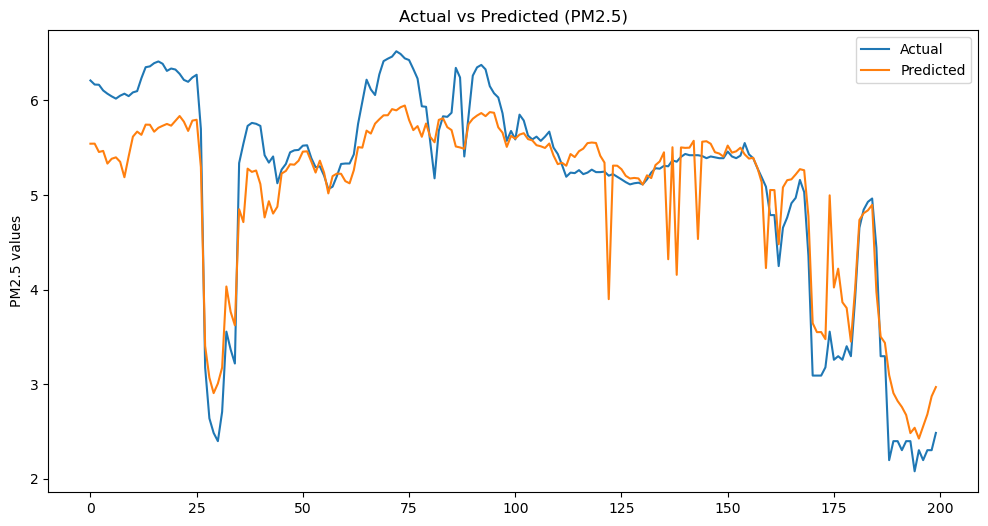

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title("Actual vs Predicted (PM2.5)")
plt.ylabel("PM2.5 values")
plt.legend()
plt.show()

### Trying to figure out which features are most important

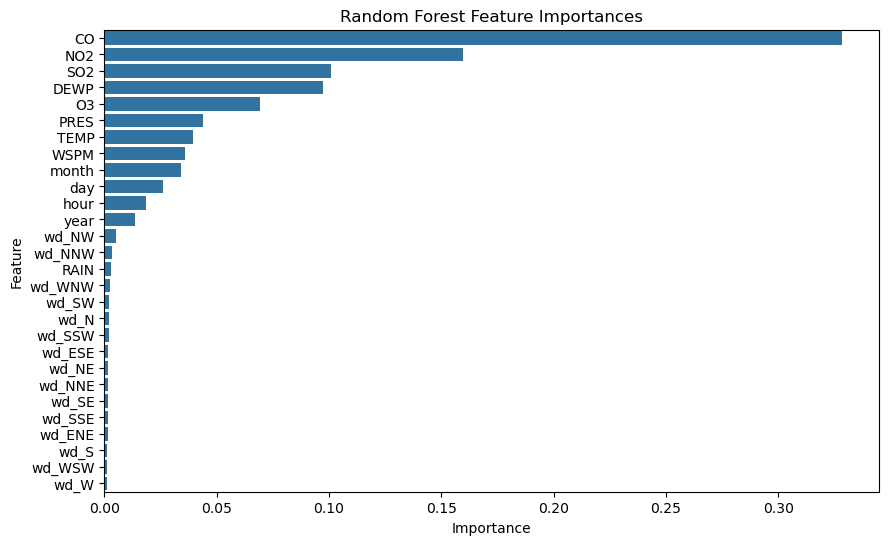

In [53]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Random Forest Feature Importances")
plt.show()

### Removing those features that are not important

In [54]:
low_importance_features = [
    'wd_NNW',
    'day',
    'wd_SW',
    'wd_WNW',
    'RAIN',
    'wd_SSW',
    'wd_ESE',
    'wd_SE',
    'wd_SSE',
    'wd_N',
    'wd_S',
    'wd_NNE',
    'wd_WSW',
    'wd_NE',
    'wd_ENE',
    'wd_W',
    'wd_NW',
]

X_encoded_reduced = X_encoded.drop(columns=low_importance_features)
train = X_encoded_reduced[(X_encoded_reduced['year'] >= 2013) & (X_encoded_reduced['year'] <= 2016)]
test = X_encoded_reduced[(X_encoded_reduced['year'] == 2017) & (X_encoded_reduced['month'] <= 2)]
X_train = train
y_train = y.loc[train.index]
X_test = test
y_test = y.loc[test.index]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train.head()


,year,month,hour,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
0,2013,3,0,1.791759,1.791759,6.685861,4.488636,0.1,1021.1,-18.6,4.4
1,2013,3,1,1.791759,1.791759,6.685861,4.488636,-0.3,1021.5,-19.0,4.0
2,2013,3,2,1.791759,1.791759,6.552508,3.970292,-0.7,1021.5,-19.8,4.6
3,2013,3,3,1.945910,1.791759,6.552508,3.970292,-1.0,1022.7,-21.2,2.8
4,2013,3,4,1.791759,1.791759,6.398595,4.304065,-1.3,1023.0,-21.4,3.6


In [55]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='log2', min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=25)

In [56]:
y_pred = rf_model.predict(X_test_scaled)

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.3586677943969709
RMSE: 0.4971243827319859
R² Score: 0.8584755986030296


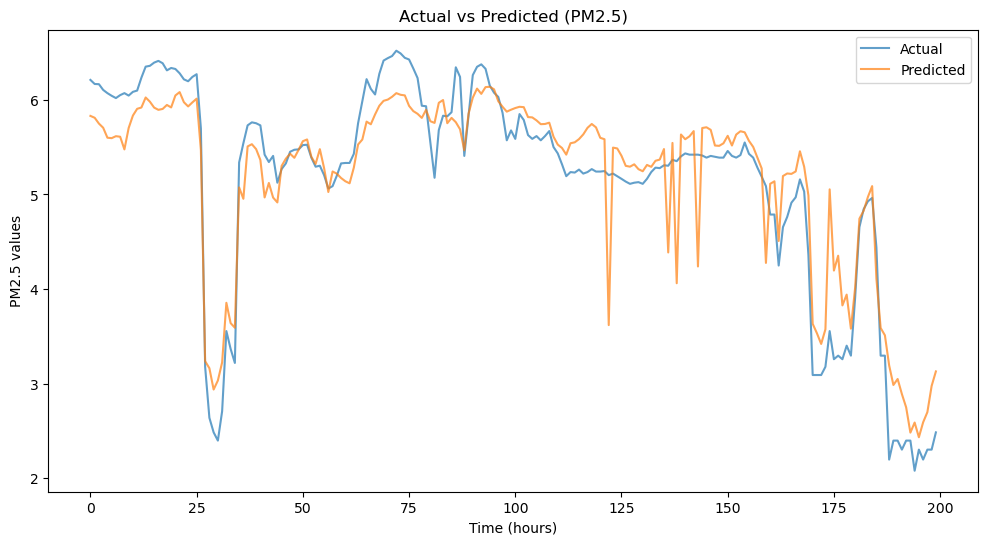

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted (PM2.5)")
plt.xlabel("Time (hours)")
plt.ylabel("PM2.5 values")
plt.legend()
plt.show()

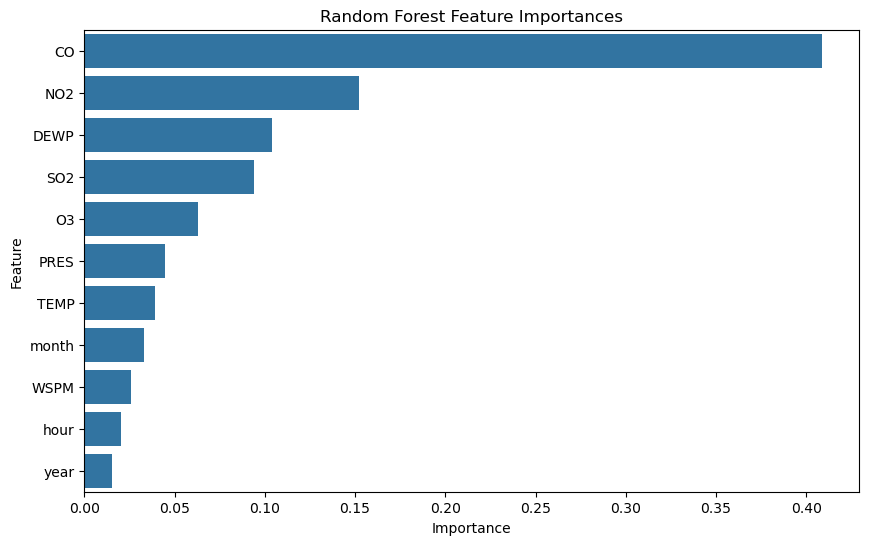

In [59]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Random Forest Feature Importances")
plt.show()

### Testing if we can remove more redundant features while keeping the accuracy at same level.

In [60]:
train = train.drop(columns=['year', 'hour', 'month','TEMP','PRES','WSPM'])
test = test.drop(columns=['year', 'hour', 'month','TEMP','PRES','WSPM'])
X_train = train
y_train = y.loc[train.index]
X_test = test
y_test = y.loc[test.index]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train.head()

,SO2,NO2,CO,O3,DEWP
0,1.791759,1.791759,6.685861,4.488636,-18.6
1,1.791759,1.791759,6.685861,4.488636,-19.0
2,1.791759,1.791759,6.552508,3.970292,-19.8
3,1.945910,1.791759,6.552508,3.970292,-21.2
4,1.791759,1.791759,6.398595,4.304065,-21.4


In [61]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='log2', min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=25)

In [62]:
y_pred = rf_model.predict(X_test_scaled)

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.39307813825009225
RMSE: 0.531724247422019
R² Score: 0.8380898304242972


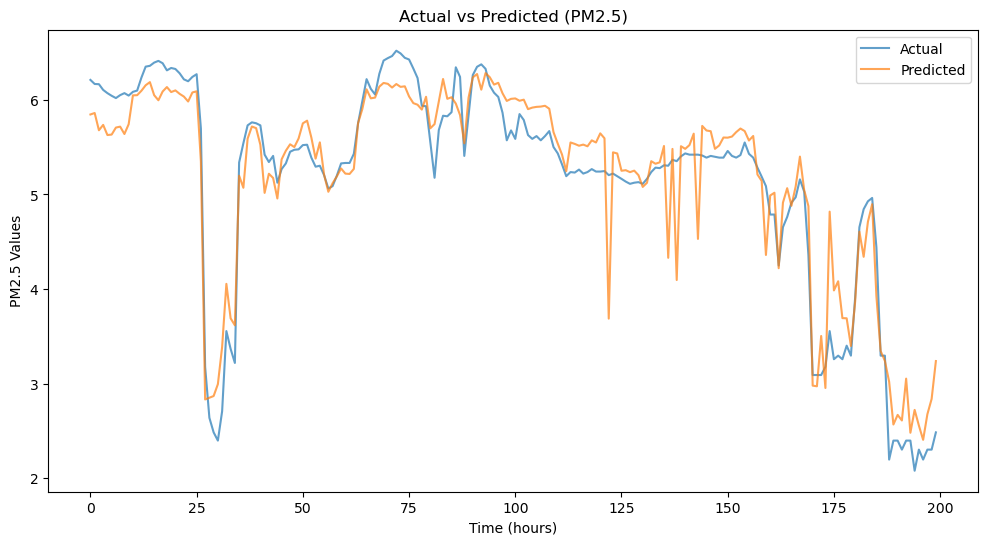

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted (PM2.5)")
plt.xlabel("Time (hours)")
plt.ylabel("PM2.5 Values")
plt.legend()
plt.show()

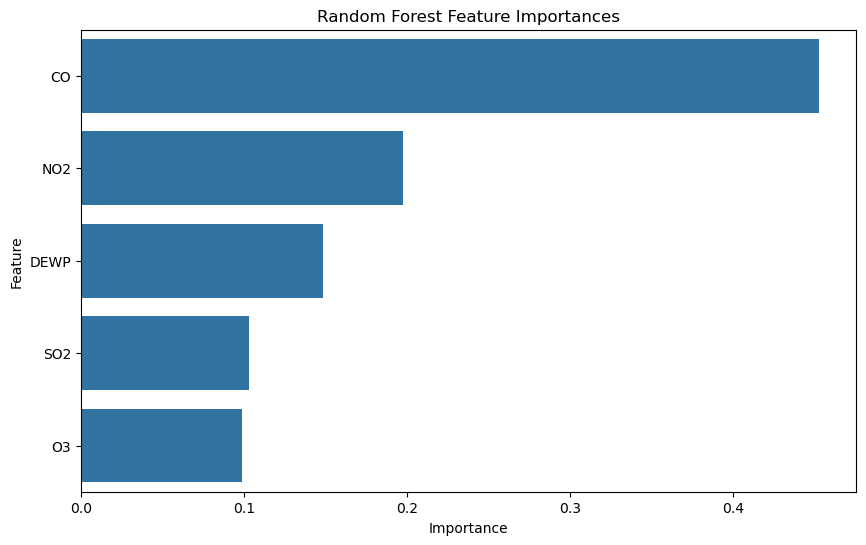

In [65]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Random Forest Feature Importances")
plt.show()

### Using Random Search CV to try to get the best hyperparameters. This part takes very long, so we have commented it, but it will take 30 mins approx

In [66]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


In [67]:
X_sample = X_encoded.sample(frac=0.1, random_state=42)
y_sample = y.loc[X_sample.index]

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid, n_iter=5, cv=3, random_state=42, n_jobs=-1
)
random_search.fit(X_sample, y_sample)
print("Best Params", random_search.best_params_)

Best Params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [69]:
random_search.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/aqi_proj/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features='log2',
                                                   min_samples_split=5,
                                                   n_estimators=200, n_jobs=-1,
                                                   random_state=25),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42)

In [70]:
print("Best Params", random_search.best_params_)
print("Best RMSE", random_search.best_score_)


Best Params {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best RMSE 0.7674833646014374


In [71]:
best_rf = random_search.best_estimator_

y_pred_tuned = best_rf.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2 = r2_score(y_test, y_pred_tuned)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.38910087682733546
RMSE: 0.5276107317482569
R²: 0.8405852734942157


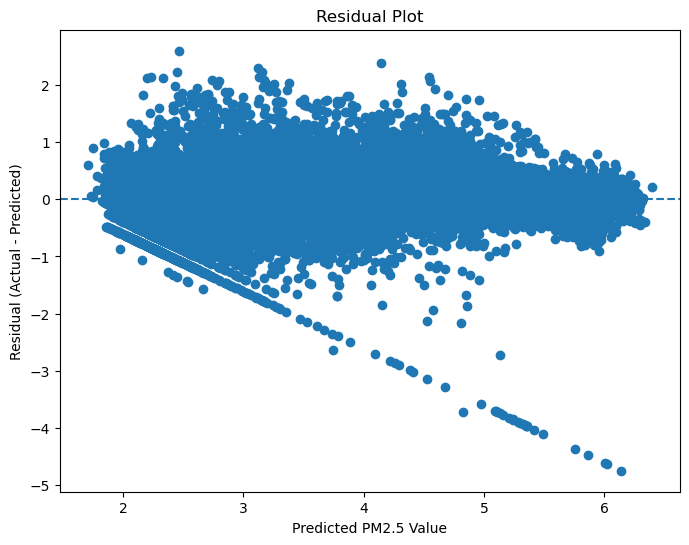

In [72]:
y_pred = best_rf.predict(X_test_scaled) 
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted PM2.5 Value") 
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

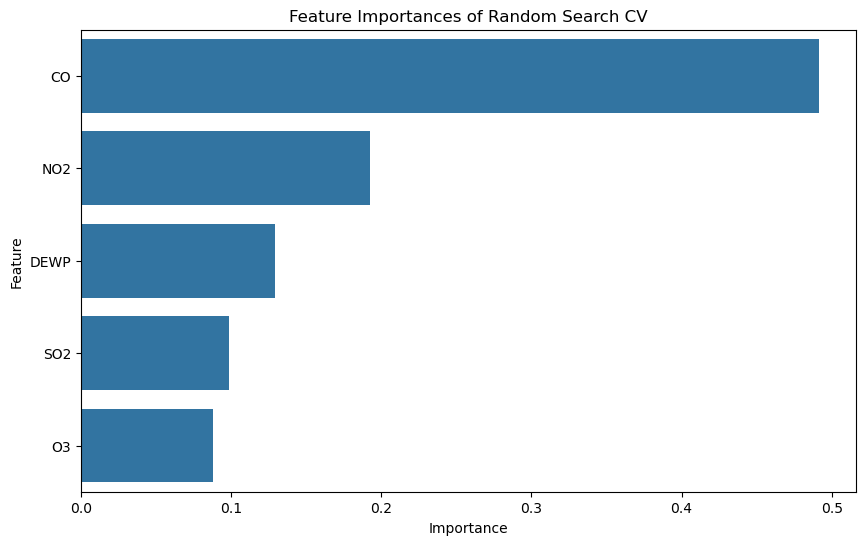

In [73]:
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances of Random Search CV")
plt.show()

In [74]:
importances = best_rf.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else range(X_train.shape[1])

feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature, imp in feat_imp[:10]:  # top 10
    print(feature, ":", imp)


CO : 0.4915628931548739
NO2 : 0.19271735442372973
DEWP : 0.12922342141175544
SO2 : 0.09835362829283988
O3 : 0.08814270271680118


### Graph for predicted vs Acutual AQI values

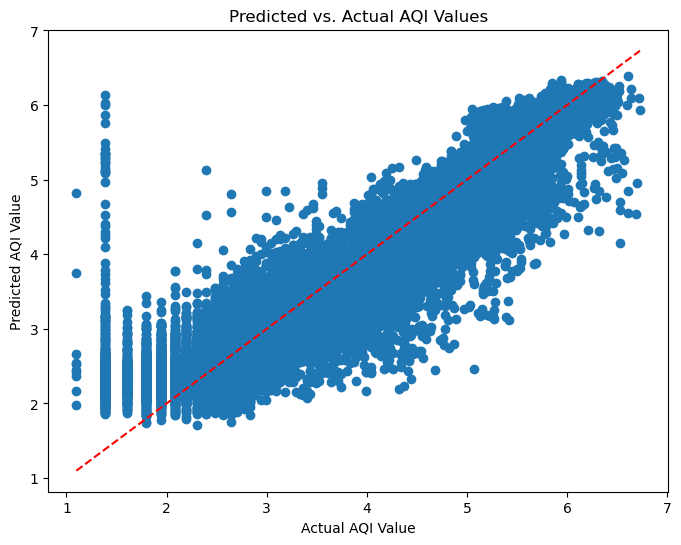

In [75]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs. Actual AQI Values")
plt.xlabel("Actual AQI Value")
plt.ylabel("Predicted AQI Value")
plt.show()


## Conclusion
### We reached an accuracy of 84-86%. Some features such as day, temperature and pressure did not contriubute much to AQI according to feature importance, so we removed that as they dont affect the acuracy much as well. As shown by the above graph, it shows a good accuracy, and only does worse on low AQI values, in which it highly overpredicts the value compared to actual. One explanation we think is that there might be not that much data on low AQI values or maybe the sensor readings at low level have high noise. 